### Import necessary package and problem file

In [5]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from itertools import permutations

distance = pd.read_csv('C:/Users/assd4/OneDrive/桌面/graduate/計算智慧/計算智慧MAPP.csv')

### Distance Matrix

In [6]:
distance = distance.iloc[:16,1:17]
distance.set_axis(['0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15'] , axis='columns', inplace=True) 

for i in range(len(distance)): #fill the NA
  distance.iloc[i,i+1:len(distance)] = distance.iloc[i+1:len(distance),i]

distance

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.0,1.9,5.9,6.4,2.2,0.8,1.3,4.3,4.9,1.9,3.2,6.0,1.3,2.6,3.9,3.9
1,1.9,0.0,5.0,5.5,2.9,1.4,1.3,5.6,4.0,2.2,3.9,5.2,1.2,2.2,3.2,3.8
2,5.9,5.0,0.0,3.6,7.3,5.4,7.0,3.9,1.8,4.0,4.0,3.0,5.3,3.5,2.1,2.7
3,6.4,5.5,3.6,0.0,7.3,6.0,7.7,4.5,2.2,5.3,4.5,0.5,6.0,4.1,3.3,2.2
4,2.2,2.9,7.3,7.3,0.0,1.5,1.5,3.3,6.0,3.1,3.8,7.5,2.8,3.5,5.1,5.5
5,0.8,1.4,5.4,6.0,1.5,0.0,1.0,2.5,4.1,1.6,1.0,5.9,1.6,2.0,3.3,3.6
6,1.3,1.3,7.0,7.7,1.5,1.0,0.0,3.0,5.0,2.2,1.0,6.5,1.5,2.6,4.1,4.3
7,4.3,5.6,3.9,4.5,3.3,2.5,3.0,0.0,3.9,3.2,1.4,4.8,5.5,2.9,3.5,3.3
8,4.9,4.0,1.8,2.2,6.0,4.1,5.0,3.9,0.0,3.1,3.0,1.7,4.6,2.6,2.1,0.9
9,1.9,2.2,4.0,5.3,3.1,1.6,2.2,3.2,3.1,0.0,2.3,4.8,2.2,1.1,2.2,2.3


### Caculate the total distance for route

In [7]:
def objective_value(routes):
  total_distance = 0
  for i in range(len(routes)-1):
    city1 = routes[i]
    city2 = routes[i+1] 
    total_distance += distance.iloc[city1,city2]
  return total_distance

### Construst the initial solution

In [8]:
def initial(pop_size,num_city):
  for i in range(pop_size): #Randomly generate a set of initial solutions
    solutions[i] = random.sample(range(16),16)

  for from_ in range(num_city): #Calculate visibility (reciprocal distance)
    for to_ in range(num_city):
      if from_ == to_:continue
      visibility[from_,to_] = 1/distance.iloc[from_,to_]
      
  return solutions

### Using roulette to choose the next city

In [9]:
def roullete_wheel(fitness_list_):
  sum_fitness = sum(fitness_list_)
  transition_probability = []

  for fit in fitness_list_:
    transition_probability.append(fit/sum_fitness)
      
  #caculate cummulative probility
  for i in range(len(transition_probability)-1,-1,-1): # range(start,stop,[step]) 
    total = 0.0
    j=0
    while(j<=i):
      total += transition_probability[j] 
      j += 1
    transition_probability[i] = total
  
  # roullete wheel selection
  for i in range(len(fitness_list_)):
    if transition_probability[i] > random.random():
      return i

### Update pheromone

In [10]:
def update_pheromone1(pheromone_map,evaporate_rate,Q):
  pheromone_map *= (1-evaporate_rate) #Pheromone evaporation
  for solution in solutions:
    for j in range(num_city-1):
      city1 = solution[j]
      city2 = solution[j+1]
        #Pheromone intensification
      pheromone_map[city1,city2] += Q/distance.iloc[city1,city2]
  return pheromone_map

### Construct one solution

In [11]:
def one_solution_construction(alpha,beta):
  candidates = []
  one_solution = np.arange(num_city,dtype=int)

  for i in range(num_city): #Create candidate cities
    candidates.append(i)

  current_city = random.choice(candidates) #create starting city
  one_solution[0] = current_city #starting city
  candidates.remove(current_city)

  for i in range(1,num_city-1): #The first city has been selected
    fitness_list = []
    for city in candidates: #Calculate the fitness of all candidate cities
      fitness = pow(pheromone_map[current_city][city],alpha)*\
            pow(visibility[current_city][city],beta)
      fitness_list.append(fitness)
    #Use the roulette method to choose the next city
    #The higher the fitness, the easier it is to be selected
    next_city = candidates[ roullete_wheel(fitness_list) ]
    candidates.remove(next_city)
    one_solution[i] = next_city
    
    current_city = next_city #move to next city
  one_solution[-1] = candidates.pop() #last city
  return one_solution

### Construst the solutions by all ant

In [12]:
def each_ant_construct_solution(alpha,beta):
  for i in range(pop_size):
    solutions[i] = one_solution_construction(alpha,beta)               
    fitness_value[i] = objective_value(solutions[i])
  
  return solutions,fitness_value

### Plot the convergency history

In [13]:
def plot(results):
  X = []
  Y = []
  for i in range(iter):
    X.append(i)
    Y.append(results[i])
  plt.plot(X,Y,color='green')
  plt.plot(X,Y,color='green')
  plt.xlabel('Number of iteration',size = 15)
  plt.ylabel('fitness value',size = 15)
  plt.title('ACO optimization ',size = 15)
  plt.show()

### Main algorithm

In [14]:
def ACO(iter,pop_size,num_city,evaporate_rate,Q,alpha,beta):
  best_obj_value = 100
  best_solution = np.arange(num_city)
  results_solution,results_fitness = [],[]
  initial(pop_size,num_city)

  for i in range(iter):
    one_solution_construction(alpha,beta)
    each_ant_construct_solution(alpha,beta)
    update_pheromone1(pheromone_map,evaporate_rate,Q)

    #Update the best solution
    for j in range(pop_size):
      if fitness_value[j] < best_obj_value:
        best_obj_value = fitness_value[j]
        best_solution = solutions[j]

    print('iteration is :',i,'Best solution',best_solution,'Best fitness',best_obj_value)

    results_solution.append(best_solution)
    results_fitness.append(best_obj_value)
  print('final solution :',results_solution[-1],'final distance :',results_fitness[-1])
  plot(results_fitness)
  return results_fitness[-1]

In [15]:
def ACO2(iter,pop_size,num_city,evaporate_rate,Q,alpha,beta):
  best_obj_value = 100
  best_solution = np.arange(num_city)
  results_solution,results_fitness = [],[]
  initial(pop_size,num_city)
  for i in range(iter):
    one_solution_construction(alpha,beta)
    each_ant_construct_solution(alpha,beta)
    update_pheromone1(pheromone_map,evaporate_rate,Q)
    for j in range(pop_size):
      if fitness_value[j] < best_obj_value:
        best_obj_value = fitness_value[j]
        best_solution = solutions[j]
    results_solution.append(best_solution)
    results_fitness.append(best_obj_value)
  return results_fitness[-1]

### Using full factor design to tuning parameter
We have 3 parameter ,evaporate_rate,Q,pheromone_factor and visibility_factor.  
Each parameter have 3 level (high,medium,low)

In [18]:
#initialize
pop_size = 100
num_city = len(distance)
iter = 100

pheromone_map = np.ones((num_city,num_city)) #tau
visibility = np.zeros((num_city,num_city)) #eta
solutions = np.zeros((pop_size,num_city),dtype=int)
fitness_value = np.zeros(pop_size) 
obj_value = np.zeros(pop_size)

evaporate_rate = [0.1,0.3,0.5] #rho
Q = [3,5,10]
alpha = [1,2,3] #pheromone_factor
beta = [3,5,7] #visibility_factor

parameter = []
ACO_result3 = []
Experiment_num = 1

for rho in evaporate_rate:
  for q in Q:
    for a in alpha:
      for b in beta:
        parameter = []
        parameter.append(rho)
        parameter.append(q)
        parameter.append(a)
        parameter.append(b)
        print('Experiment:',Experiment_num,'parameter :',parameter,'objective value :',ACO2(iter,pop_size,num_city,rho,q,a,b))
        Experiment_num += 1

Experiment: 1 parameter : [0.1, 3, 1, 3] objective value : 21.9
Experiment: 2 parameter : [0.1, 3, 1, 5] objective value : 21.199999999999996
Experiment: 3 parameter : [0.1, 3, 1, 7] objective value : 21.199999999999996
Experiment: 4 parameter : [0.1, 3, 2, 3] objective value : 21.199999999999996
Experiment: 5 parameter : [0.1, 3, 2, 5] objective value : 21.999999999999996
Experiment: 6 parameter : [0.1, 3, 2, 7] objective value : 22.7
Experiment: 7 parameter : [0.1, 3, 3, 3] objective value : 22.7
Experiment: 8 parameter : [0.1, 3, 3, 5] objective value : 22.7
Experiment: 9 parameter : [0.1, 3, 3, 7] objective value : 22.7
Experiment: 10 parameter : [0.1, 5, 1, 3] objective value : 21.199999999999996
Experiment: 11 parameter : [0.1, 5, 1, 5] objective value : 21.199999999999996
Experiment: 12 parameter : [0.1, 5, 1, 7] objective value : 21.199999999999996
Experiment: 13 parameter : [0.1, 5, 2, 3] objective value : 21.199999999999996
Experiment: 14 parameter : [0.1, 5, 2, 5] objective 

### Run algorithm

iteration is : 0 Best solution [ 7 10  5  0 12  1  6  4  9 13 14  2  8 15  3 11] Best fitness 21.9
iteration is : 1 Best solution [ 3 11  8 15 13  9  5  0 12  1  6 10  7  4 14  2] Best fitness 21.9
iteration is : 2 Best solution [12  1  6  5  0  9 13 14  2  8 15  3 11 10  7  4] Best fitness 21.9
iteration is : 3 Best solution [ 6  8 15  3 11  2 14 13  9  5  0 12  1  4  7 10] Best fitness 21.9
iteration is : 4 Best solution [ 4  5  0 12  1  6 10  7  9 13 14  2  8 15  3 11] Best fitness 21.9
iteration is : 5 Best solution [14  2  8 15  6  7 10  5  0 12  1  9 13 11  3  4] Best fitness 21.9
iteration is : 6 Best solution [12  1  6  7 10  5  0  8 15 13  9 14  2 11  3  4] Best fitness 21.9
iteration is : 7 Best solution [ 7 10  6  4  5  0 12  1  9 13 14  2  8 15  3 11] Best fitness 21.199999999999996
iteration is : 8 Best solution [ 9 13 14  2  8 15  3 11  7 10  6  5  0 12  1  4] Best fitness 21.199999999999996
iteration is : 9 Best solution [12  1  6  5  0  9 13 14  2  8 15  3 11 10  7  4] 

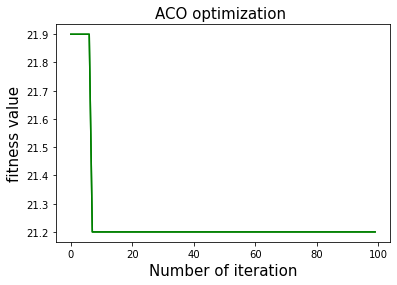

21.199999999999996

In [46]:
iter = 100
evaporate_rate = 0.1 #rho
Q = 5
alpha = 1 #pheromone_factor
beta = 7 #visibility_factor
pop_size = 100
num_city = len(distance)

ACO(iter,pop_size,num_city,evaporate_rate,Q,alpha,beta)

### Run algorithm 100 times to verify the result
Conclusion : In TSP, ACO finds the best solution every time.

In [48]:
ACO_result2=[]
for i in range(100):
  result = ACO2(iter,pop_size,num_city,evaporate_rate,Q,alpha,beta)
  ACO_result2.append(result)
  print('ACO round :',i+1,'final objective value :',result)

averge_value_2 = np.mean(ACO_result2)
std_2 = np.std(ACO_result2)
print('averge =',averge_value_2 ,'standard deviation',std_2)

ACO round : 1 final objective value : 21.199999999999996
ACO round : 2 final objective value : 21.199999999999996
ACO round : 3 final objective value : 21.199999999999996
ACO round : 4 final objective value : 21.199999999999996
ACO round : 5 final objective value : 21.199999999999996
ACO round : 6 final objective value : 21.199999999999996
ACO round : 7 final objective value : 21.199999999999996
ACO round : 8 final objective value : 21.199999999999996
ACO round : 9 final objective value : 21.199999999999996
ACO round : 10 final objective value : 21.199999999999996
ACO round : 11 final objective value : 21.199999999999996
ACO round : 12 final objective value : 21.199999999999996
ACO round : 13 final objective value : 21.199999999999996
ACO round : 14 final objective value : 21.199999999999996
ACO round : 15 final objective value : 21.199999999999996
ACO round : 16 final objective value : 21.199999999999996
ACO round : 17 final objective value : 21.199999999999996
ACO round : 18 final ob